In [1]:
if 'already_executed' not in globals():
    already_executed = False

if not already_executed:
    import os
    os.chdir("../")
    %load_ext autoreload
    %autoreload 2
    already_executed = True

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
from src.pricers.pricers import LSPINStepsPricer as LSPIPricer, AmericanMonteCarloPricer
from src.samplers.samplers import GeometricBrownianMotionPutSampler

In [4]:
sampler = GeometricBrownianMotionPutSampler(**{
    "asset0": 100.0,
    "sigma": 0.2,
    "r": 0.05,
    "strike": 100.0,
    "t": 1.0,
    "cnt_times": 30,
    "seed": 42, 
    "cnt_trajectories": 500_000
})

In [5]:
pricer = LSPIPricer(sampler=sampler, **{
    "iterations": 100,
    "lambda_reg": 0,
    "tol": 1e-9
})

In [6]:
_ = pricer.price(test=False, quiet=False)

GBM sampling:   0%|          | 0/29 [00:00<?, ?it/s]

Iteration 0: ||Δw|| = 357.897013316
Iteration 1: ||Δw|| = 77.019935240
Iteration 2: ||Δw|| = 15.621061824
Iteration 3: ||Δw|| = 1.937502678
Iteration 4: ||Δw|| = 0.199344618
Iteration 5: ||Δw|| = 0.015933687
Iteration 6: ||Δw|| = 0.000401177
Iteration 7: ||Δw|| = 0.001636986
Iteration 8: ||Δw|| = 0.000817216
Iteration 9: ||Δw|| = 0.000887223
Iteration 10: ||Δw|| = 0.003148028
Iteration 11: ||Δw|| = 0.000691755
Iteration 12: ||Δw|| = 0.000128433
Iteration 13: ||Δw|| = 0.000000000
Converged after 13 iterations
q-value at 0: 6.424310565891549
Option price: 5.853921309712648


In [7]:
r = -np.log(sampler.discount_factor[0, 1] / sampler.discount_factor[0, 0]) / sampler.time_deltas[0]
n_paths, n_times, _ = sampler.markov_state.shape
gamma = np.exp(-r * sampler.time_deltas[0])
phi_all_raw = pricer._basis_functions_raw(sampler.markov_state, sampler.time_grid)
phi_all = pricer._scale_features(phi_all_raw, fit=True)

phi_curr = phi_all[:, :-1, :]  # Текущие состояния (t)
phi_next = phi_all[:, 1:, :]   # Следующие состояния (t+1)
payoff = sampler.payoff
payoff_next = sampler.payoff[:, 1:]  # Выплаты в t+1

# Выравнивание в 1D
n_features = phi_all.shape[-1]
phi_all_flat = phi_all.reshape(-1, n_features)
phi_curr_flat = phi_curr.reshape(-1, n_features)
phi_next_flat = phi_next.reshape(-1, n_features)
payoff_flat = payoff.reshape(-1)
payoff_next_flat = payoff_next.reshape(-1)

In [8]:
def bellman_opt_eq(phi_curr, phi_next, payoff_next, w, gamma, w_next=None):
    if w_next is None:
        w_next = w
    return ((
        phi_curr @ w - 
        gamma * np.concat([
            payoff_next[np.newaxis], 
            (phi_next @ w_next)[np.newaxis] \
                * np.array(
                    (([1] * (n_times - 2)) + [0]) * n_paths
                )
        ]).max(axis=0)
    ) ** 2).mean()

In [9]:
bellman_opt_eq(
    phi_curr_flat, 
    phi_next_flat, 
    payoff_next_flat, 
    pricer.w, 
    gamma
)

np.float64(4.52126652952362)

In [10]:
bellman_opt_eq(
    phi_curr_flat, 
    phi_next_flat, 
    payoff_next_flat, 
    pricer.w * 0.98, 
    gamma
)

np.float64(4.691706512630754)

In [11]:
bellman_opt_eq(
    phi_curr_flat, 
    phi_next_flat, 
    payoff_next_flat, 
    pricer.w * 0.98, 
    gamma,
    pricer.w
)

np.float64(4.706121517985248)

In [12]:
def price(phi_all, n_paths, payoff, w, gamma):
    pv_payoffs = np.zeros(n_paths)
    for p in range(n_paths):
        for t in range(n_times):
            phi_t = phi_all[p, t]
            Q_cont = phi_t @ w
            payoff_t = payoff[p, t]
            
            disc_factor = gamma**t
            if payoff_t >= Q_cont or t == n_times - 1:
                pv_payoffs[p] = disc_factor * payoff_t
                break
    return pv_payoffs.mean()

In [13]:
price(
    phi_all,
    n_paths, 
    sampler.payoff,
    pricer.w,
    gamma
)

np.float64(5.853921309712652)

In [14]:
price(
    phi_all,
    n_paths, 
    sampler.payoff,
    pricer.w * 0.98,
    gamma
)

np.float64(5.812551562207633)

In [15]:
price(
    phi_all,
    n_paths, 
    sampler.payoff,
    pricer.w * 100,
    gamma
)

np.float64(5.453519207175372)

In [16]:
pricer.w

array([   1.75926799,  151.70295705, -206.91256167,   62.02408733,
          7.58748357,   24.11791911,   11.75143876])

# Exercise Boundary

AMC price train:  93%|#########3| 27/29 [00:01<00:00, 31.17it/s]

/Users/vanyavorobiov/projects/AmericanOptionsPricingApproaches/src/pricers/american_monte_carlo.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


{'train': {'price': 6.067054921116857,
  'upper_bound': 10.844297398515911,
  'lower_bound': 5.57371691591654,
  'std': 7.238512571865822}}

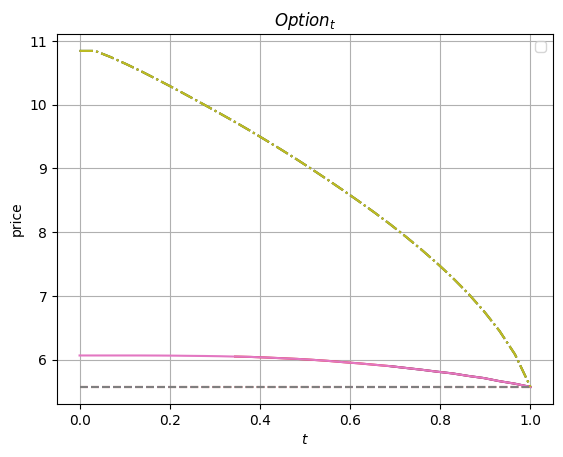

In [17]:
from src.pricers.american_monte_carlo import AmericanMonteCarloPricer
pricer_lsmc = AmericanMonteCarloPricer(sampler=sampler, degree=3, regularization_alpha=0.)
pricer_lsmc.price(test=False, quiet=False);
pricer_lsmc.result

In [18]:
def find_rightmost_root(f, bounds, tol=1e-2, step=None):
    a, b = bounds
    if step is None:
        step = (b - a) / 1_000
    
    x = b
    while x >= a:
        if abs(f(x)) < tol:
            return x
        x -= step
    if abs(f(a)) < tol:
        return a
    
    return None

  0%|          | 0/30 [00:00<?, ?it/s]

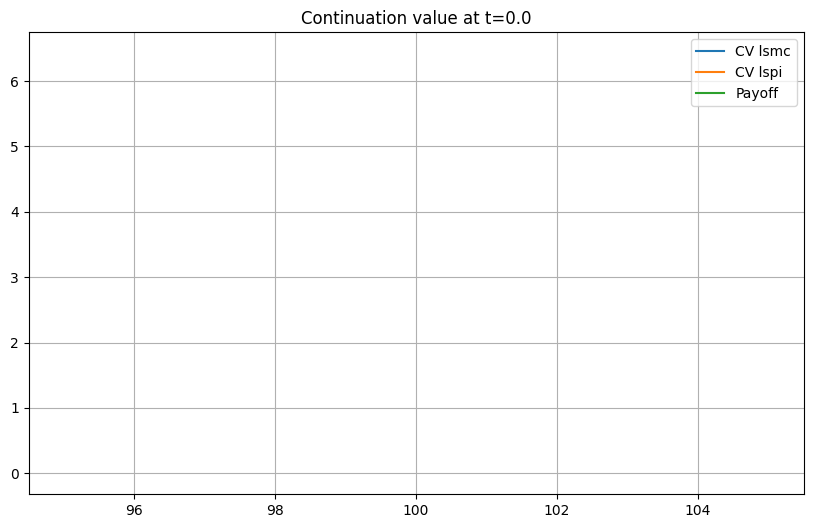

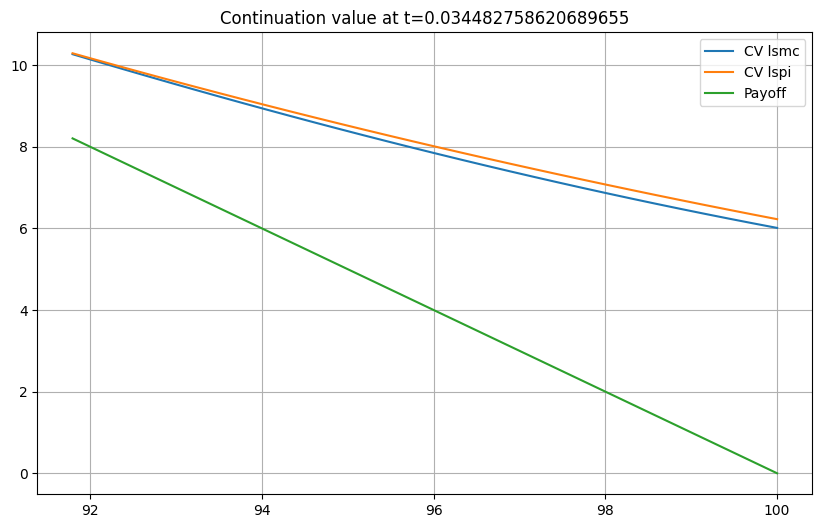

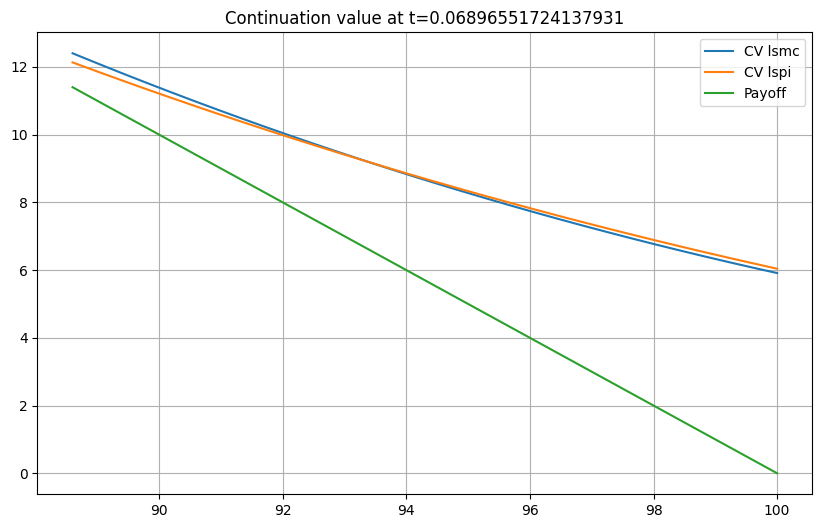

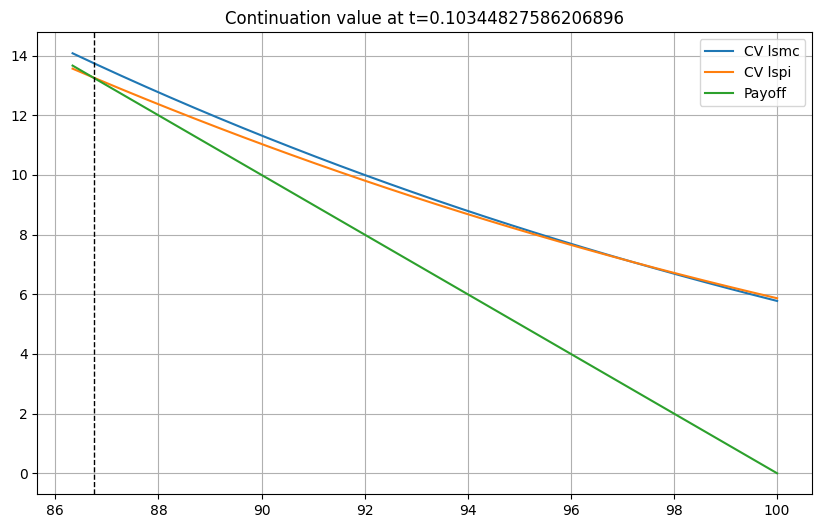

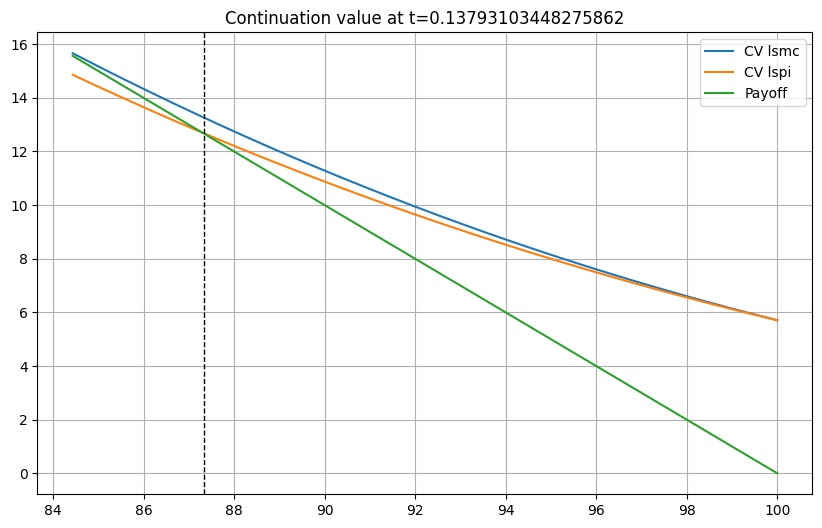

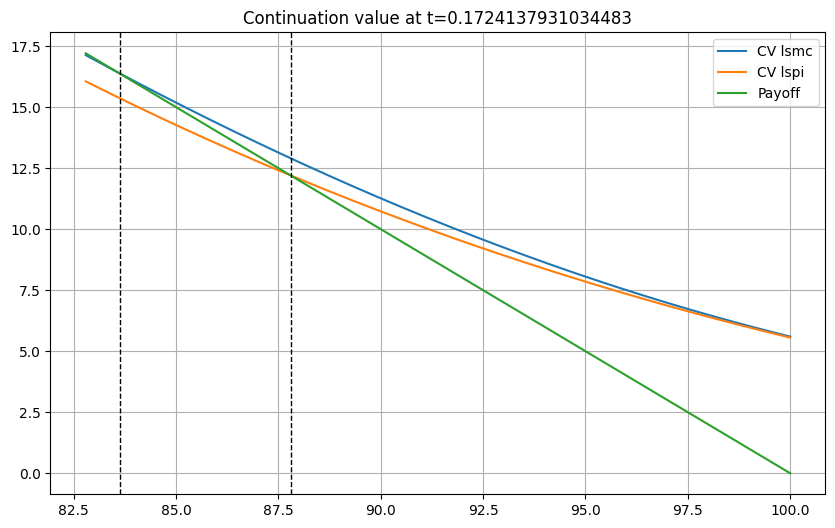

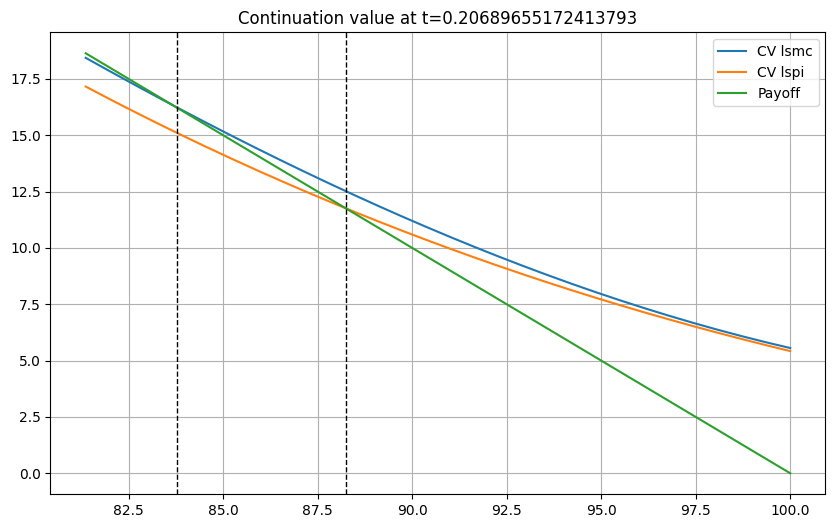

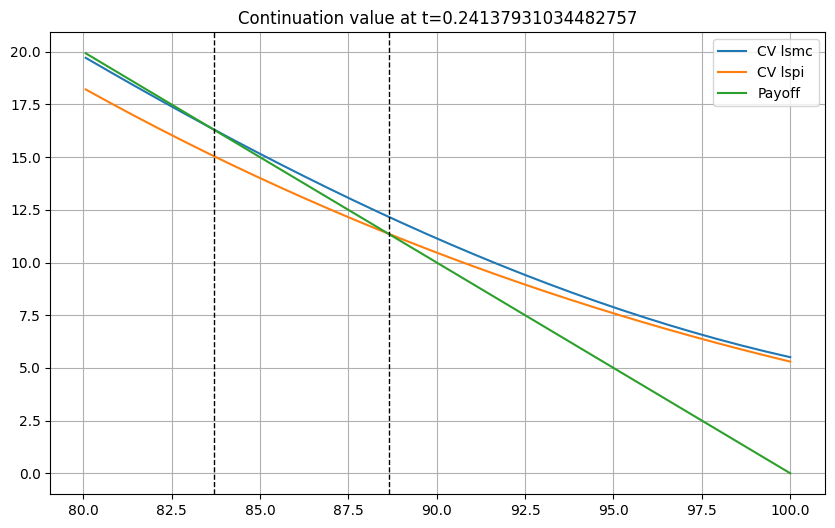

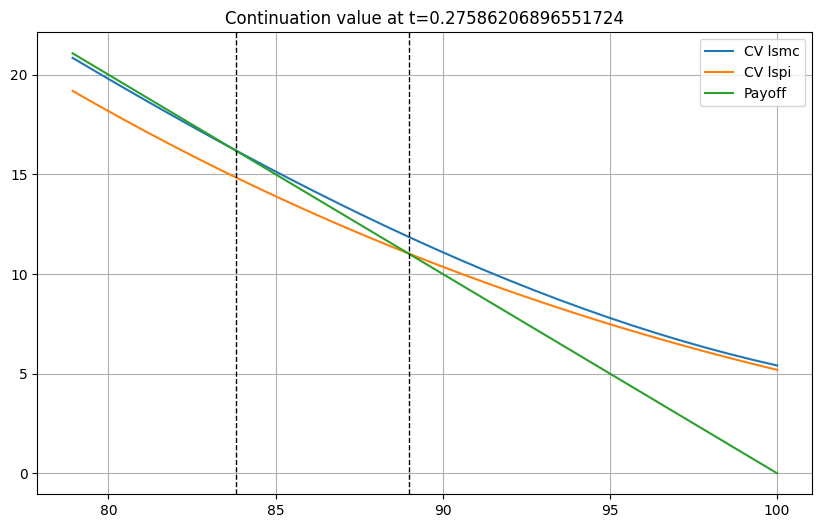

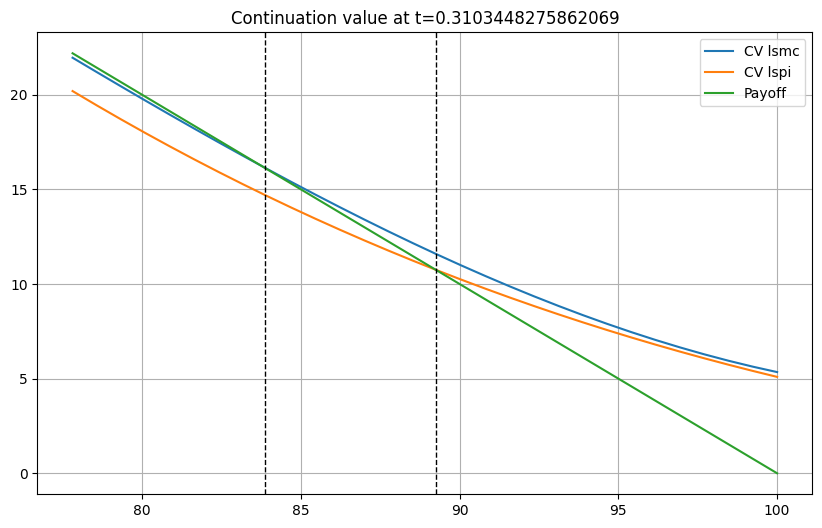

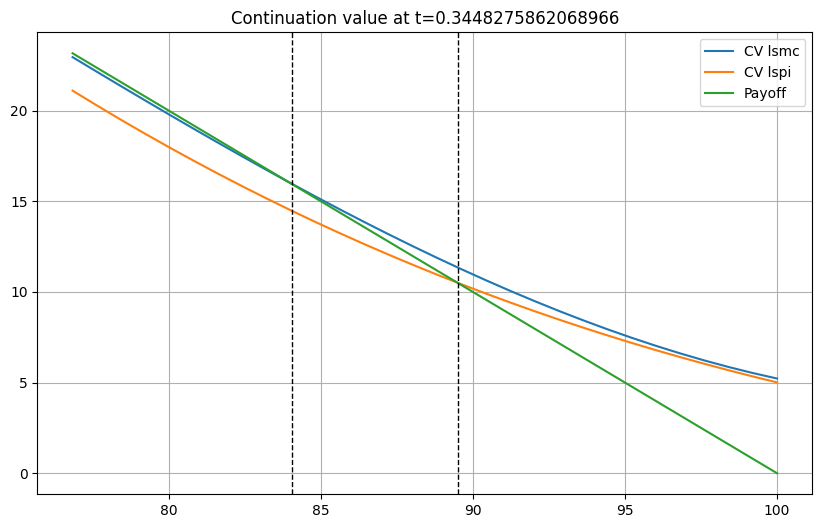

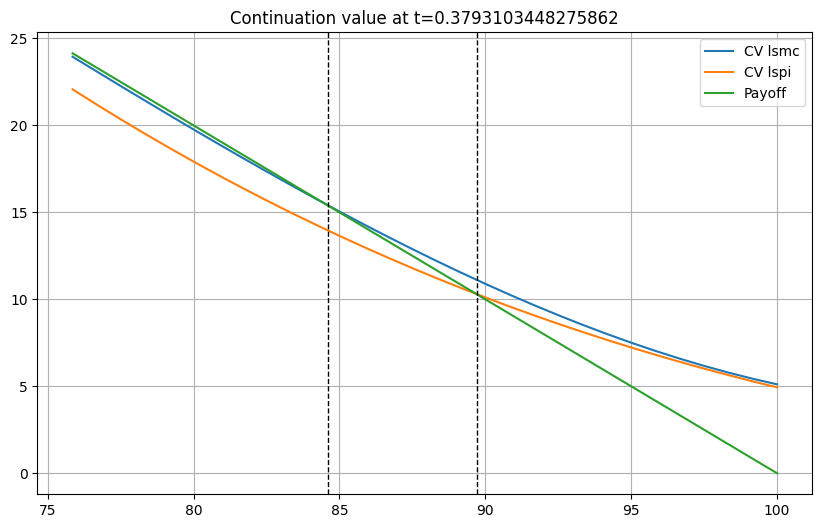

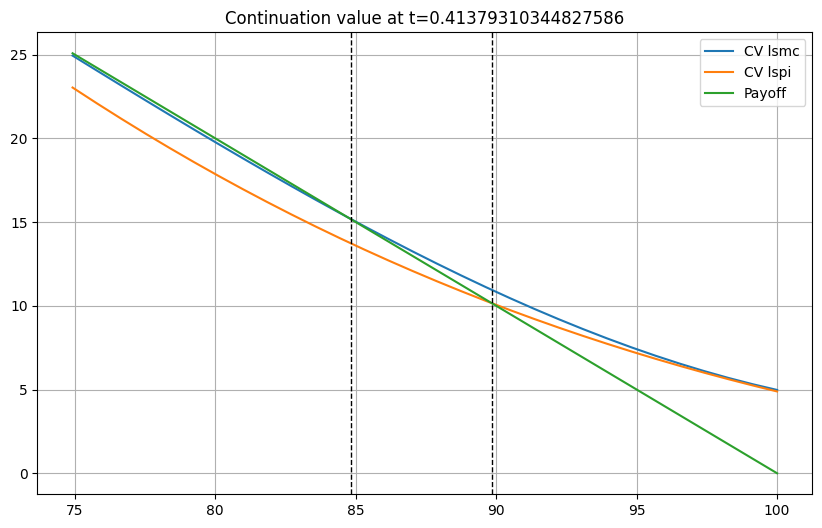

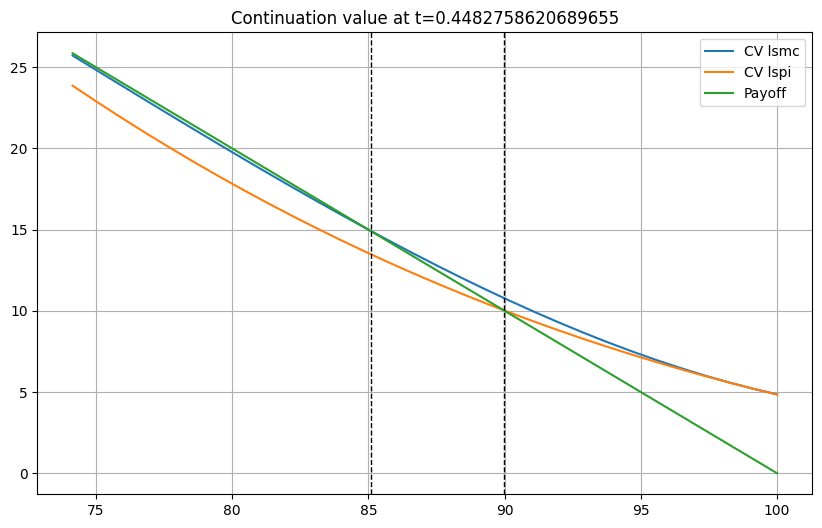

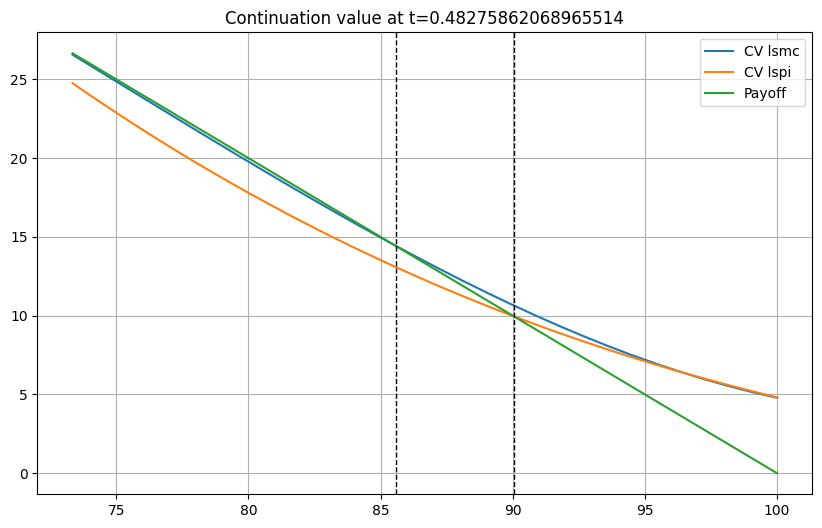

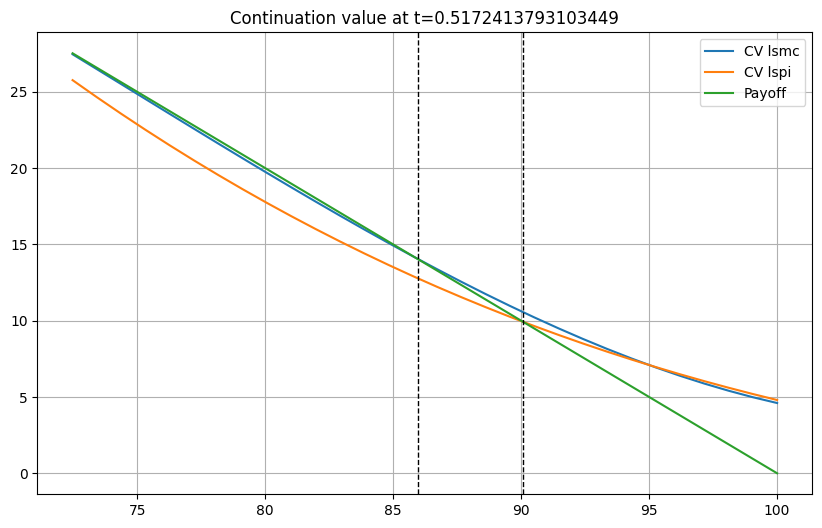

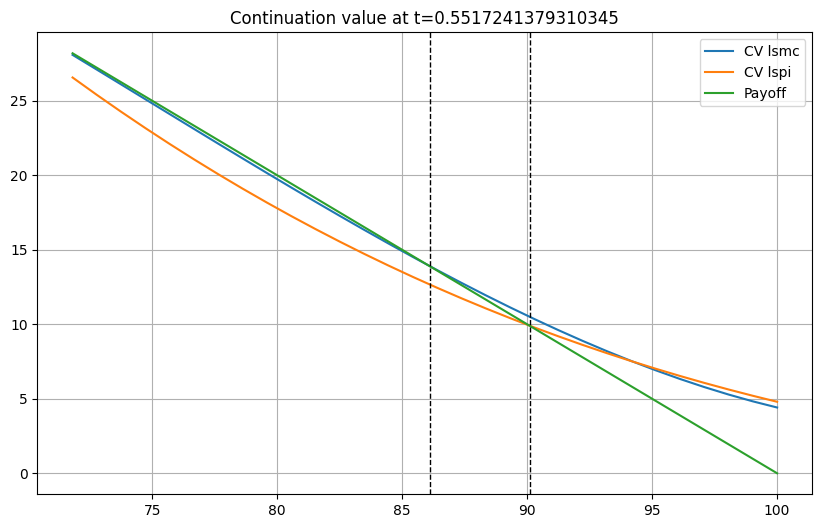

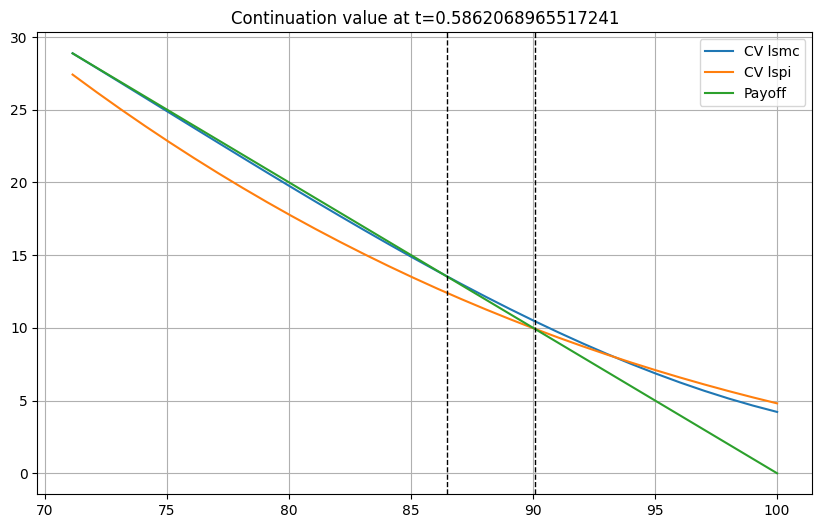

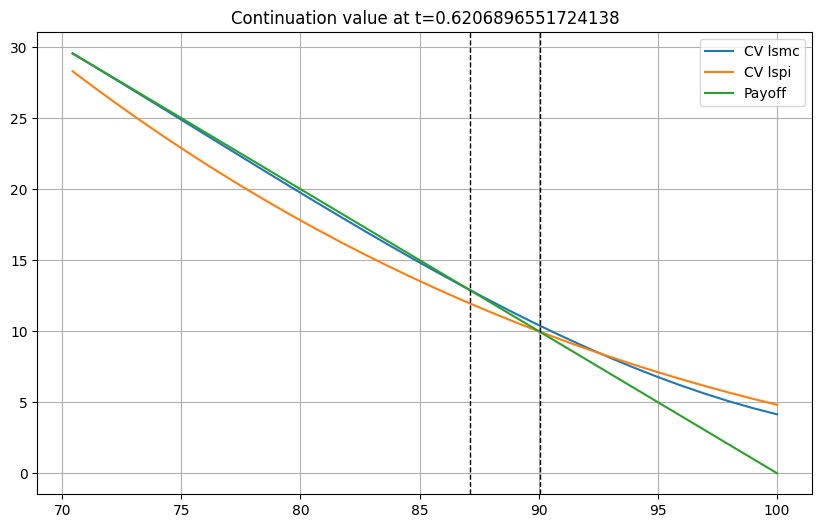

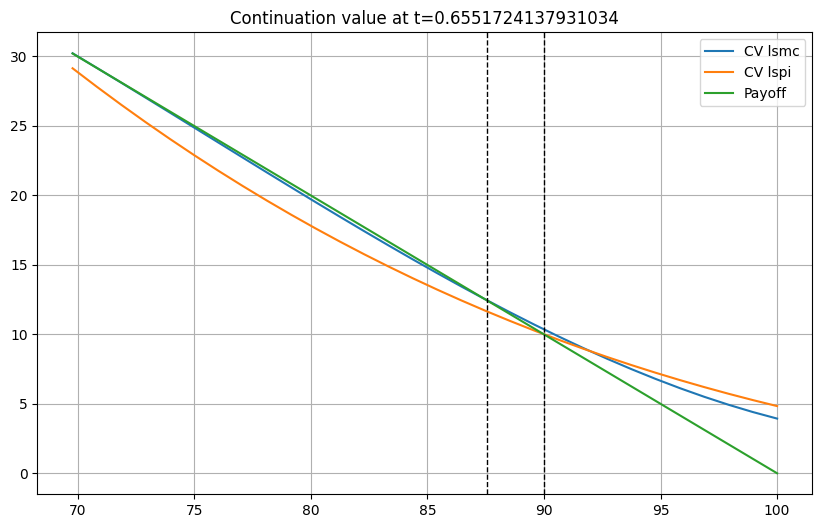

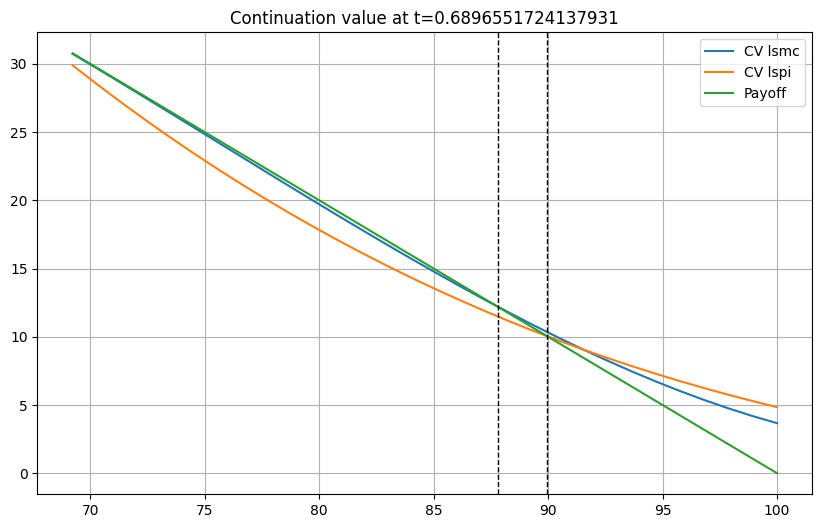

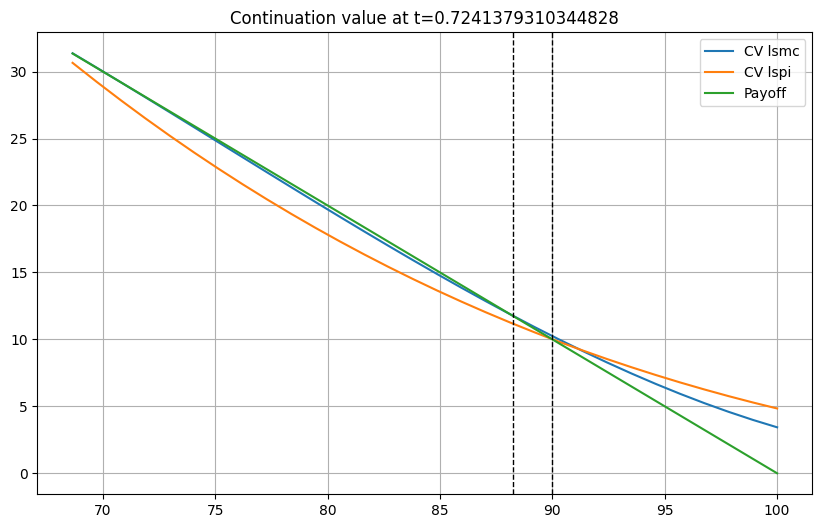

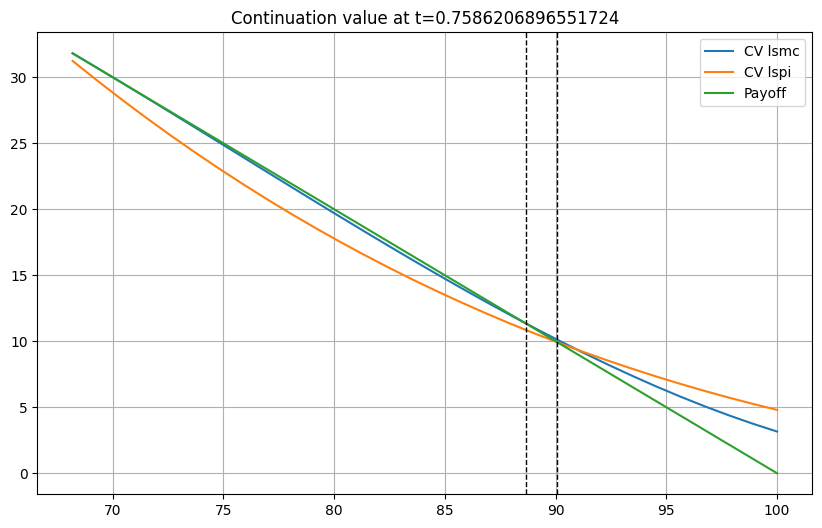

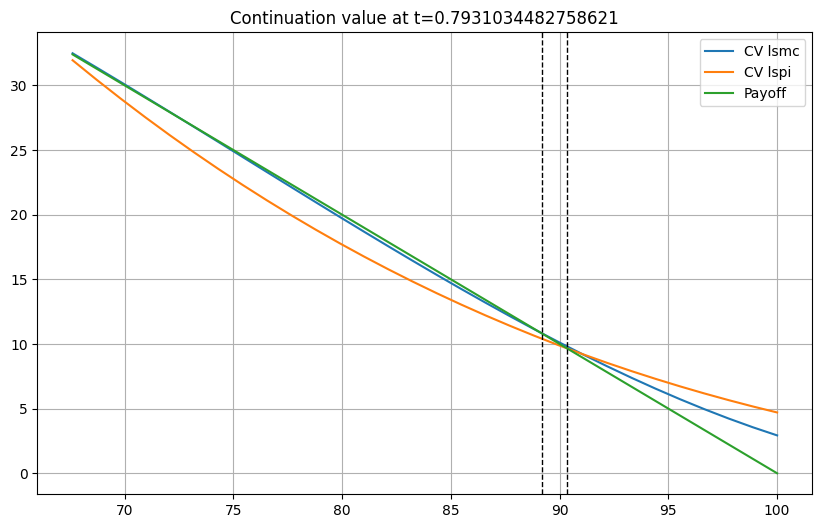

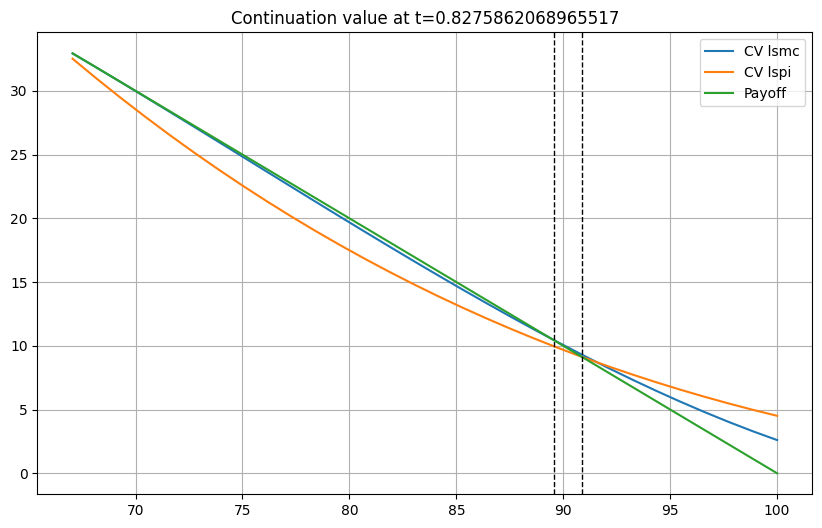

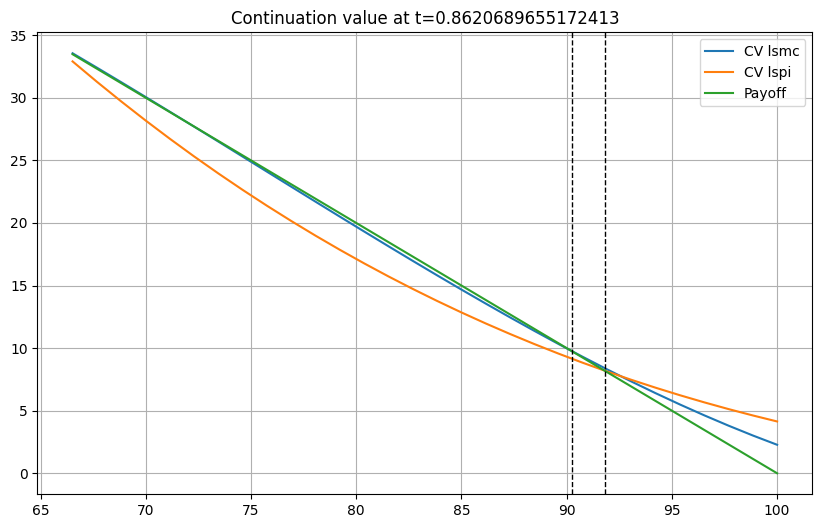

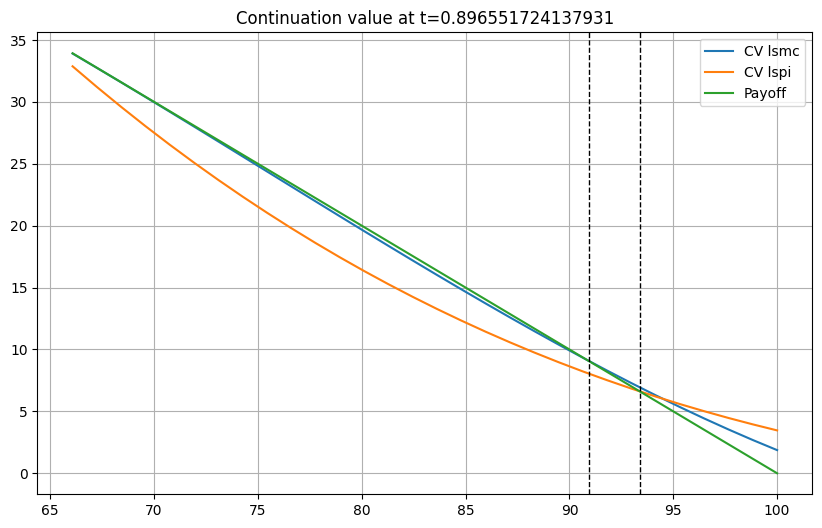

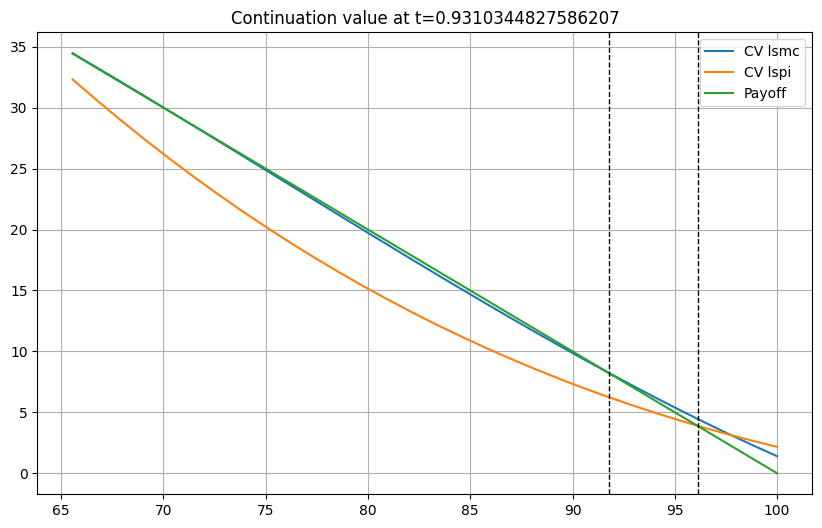

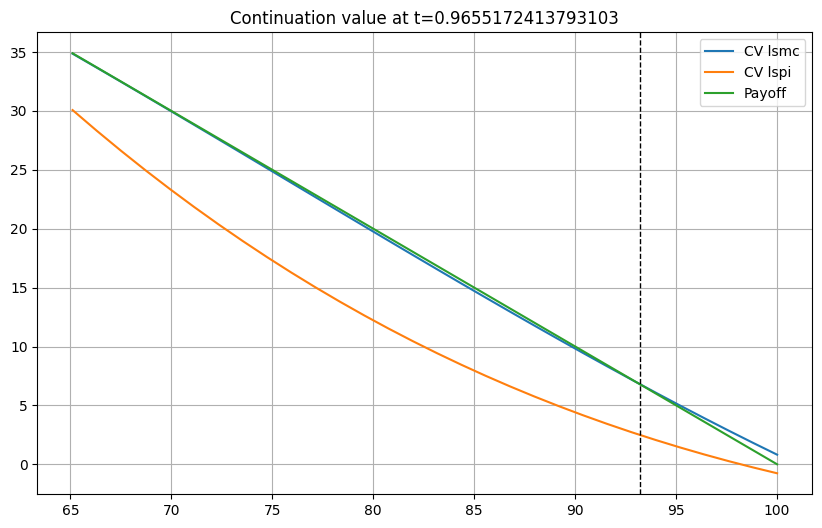

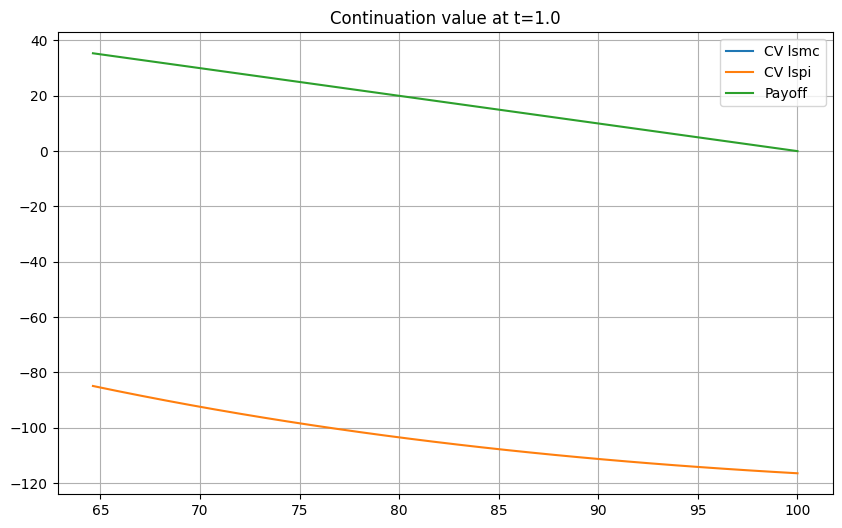

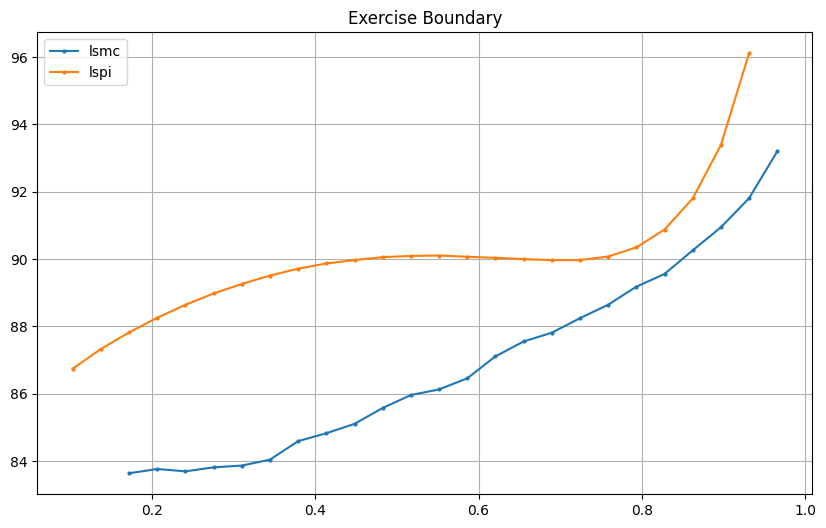

In [19]:
exercise_boundary_lsmc = []
exercise_boundary_lspi = []
for i, t in tqdm(list(
    enumerate(sampler.time_grid)
)):
    func_payoff = lambda x: np.clip(100 - x, a_min=0, a_max=np.inf)

    func_continuation_value_lsmc = lambda x: pricer_lsmc.continuation_value(x, t)
    func_continuation_value_lspi = lambda x: pricer.continuation_value(x, t)

    root_lsmc = find_rightmost_root(
        f = lambda x: func_payoff(x) - func_continuation_value_lsmc(x),
        bounds=(np.percentile(sampler.markov_state[:, i, 0], 0.99)-1e-6, 100.)
    )
    root_lspi = find_rightmost_root(
        f = lambda x: func_payoff(x) - func_continuation_value_lspi(x),
        bounds=(np.percentile(sampler.markov_state[:, i, 0], 0.99)-1e-6, 100.)
    )

    exercise_boundary_lsmc.append(root_lsmc)
    exercise_boundary_lspi.append(root_lspi)

    plt.figure(figsize=(10, 6))
    plt.title(f"Continuation value at t={t}")
    grid = np.linspace(np.percentile(sampler.markov_state[:, i, 0], 0.99), 100, 30)
    plt.plot(grid, [func_continuation_value_lsmc(x) for x in grid], label="CV lsmc")
    plt.plot(grid, [func_continuation_value_lspi(x) for x in grid], label="CV lspi")
    plt.plot(grid, func_payoff(grid), label="Payoff")
    if root_lsmc is not None:
        plt.axvline(root_lsmc, linestyle="--", color='black', linewidth=1)
    if root_lspi is not None:
        plt.axvline(root_lspi, linestyle="--", color='black', linewidth=1)
    plt.legend()
    plt.grid()
    plt.show()

plt.figure(figsize=(10, 6))
plt.title("Exercise Boundary")
plt.plot(sampler.time_grid, exercise_boundary_lsmc, "-o", markersize=2, label="lsmc")
plt.plot(sampler.time_grid, exercise_boundary_lspi, "-o", markersize=2, label="lspi")
plt.legend()
plt.grid()
plt.show()

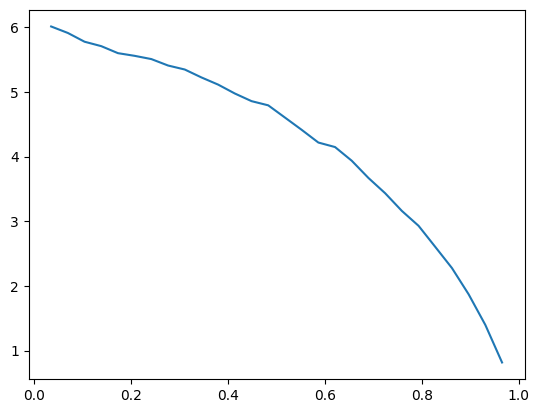

In [20]:
plt.plot(sampler.time_grid, [pricer_lsmc.continuation_value(100, t) for t in sampler.time_grid])

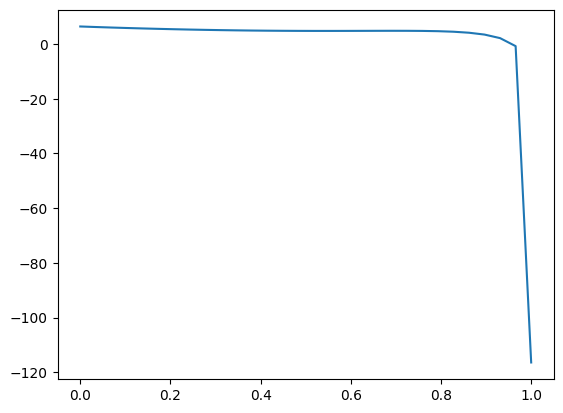

In [21]:
plt.plot(sampler.time_grid, [pricer.continuation_value(100, t) for t in sampler.time_grid])